In [1]:
import torch 
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import matplotlib.pyplot as plt 

/home/valentin/Desktop/deep_learning/practice_learn/model_implementation/simpleVIT/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_size = 32
patch_size = 8
if image_size % patch_size != 0: 
    raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

image = torch.rand(10, image_size, image_size, 3) 


def patch_image(images, patch_size): 
    patches = []
    image_size = images.shape[-1]

    for row_idx in range(0, image_size, patch_size): 
        for col_idx in range(0, image_size, patch_size):
            patch = images[:, :, :, row_idx: row_idx + patch_size, col_idx: col_idx + patch_size]
            patches.append(patch)

    patches = torch.stack(patches, dim=-3) # (B, S+1, N, c, P, P)
    B, S, c, N, p, _ = patches.shape
    patches = patches.view(B, S, N, c, p*p) # (B, S+1, N, c, P**2)
    return patches

# print(len(patches))
# for i, patch in enumerate(patches): 
#     plt.imshow(patch[0])
#     plt.show()


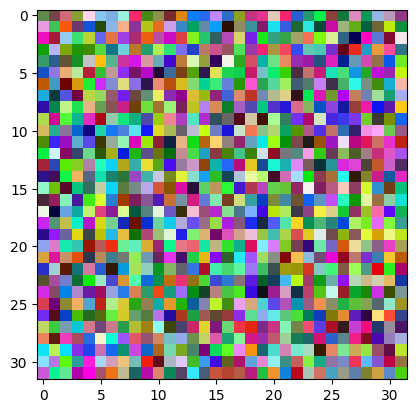

torch.Size([10, 5, 3, 32, 32])


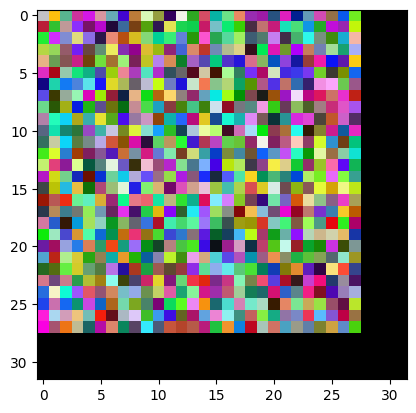

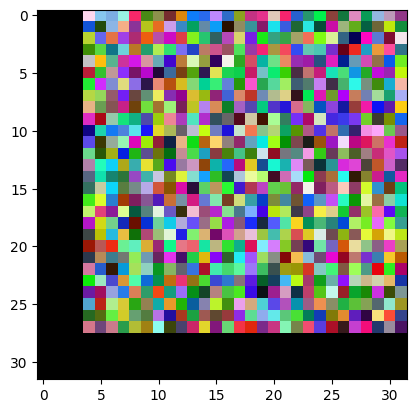

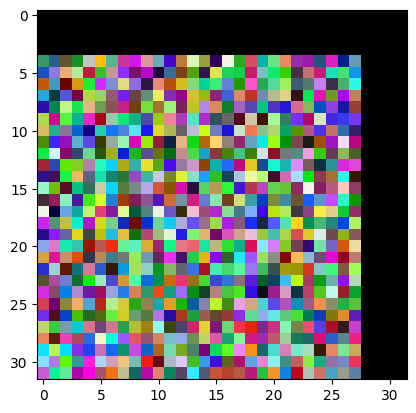

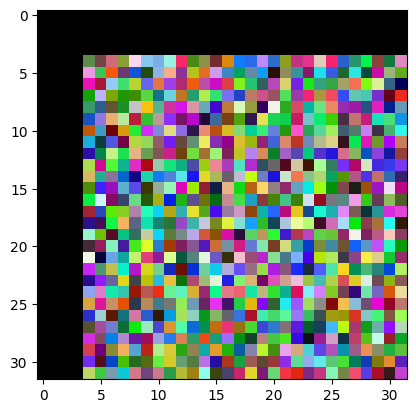

In [3]:
MODE = {
    "left-up" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : patch_size // 2, 
        "pad" : (0, 0 , patch_size // 2, patch_size // 2)
    }, 
    "right-up" : {
        "crop_x" : 0, 
        "crop_y" : patch_size // 2, 
        "pad" : (patch_size // 2, 0, 0, patch_size // 2), 
    }, 
    "left-down" : {
        "crop_x" : patch_size // 2, 
        "crop_y" : 0, 
        "pad" : (0, patch_size // 2, patch_size // 2, 0), 
    }, 
    "right-down" : {
        "crop_x" : 0, 
        "crop_y" : 0, 
        "pad" : (patch_size // 2, patch_size // 2, 0, 0), 
    }, 
}


plt.imshow(image[0])
plt.show()

shifted = [image.permute(0, 3, 1, 2)]

for mode in MODE: 
    crop = torchvision.transforms.functional.crop(image.permute(0, 3, 1, 2), MODE[mode]["crop_x"], MODE[mode]["crop_y"], image_size - patch_size//2, image_size - patch_size//2) 
    pad = torchvision.transforms.functional.pad(crop, padding=MODE[mode]["pad"])
    shifted.append(pad)

shifted = torch.stack(shifted, dim=1)
print(shifted.shape)

for i in range(1, len(MODE)+1): 
    plt.imshow(shifted[0][i].permute(1, 2, 0))
    plt.show()


In [4]:
patch_image(shifted, 8).shape

torch.Size([10, 5, 16, 3, 64])

In [5]:
device = "cuda"

In [6]:
class ShiftedPatchTokenizer(nn.Module): 

    def __init__(self, image_size, patch_size, c_out, num_classes=10): 
        super().__init__()
        if image_size % patch_size != 0: 
            raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")

        self.patch_size = patch_size
        self.image_size = image_size
        num_patches = (image_size // patch_size)**2
        self.num_patches = num_patches
        
        c_in = int(5*3*patch_size**2)
        self.linear = nn.Linear(c_in, c_out, bias=False)
        self.layer_norm = nn.LayerNorm()
        self.class_embedding = nn.Embedding(num_classes, c_out)
        self.pos_embedding = nn.Embedding(num_patches + 1, c_out)

    def forward(self, x, class_id=None): 
        """
            x : (B, c, w, h)
            out : (B, N, N*c*P**2)
        """

        shifts = self._shift_and_crop(x) 
        patches = self._patch_image(shifts)
        out = self.linear(self.layer_norm(patches))
        pos_token = self.pos_embedding(torch.arange(0, self.num_patches + 1, device=device)[None, :].type(torch.long))
        
        if class_id:
            class_token = self.class_embedding(torch.tensor(class_id, device=device)[:, None].type(torch.long)) 

        out = torch.concat([class_token, out], dim=1) + pos_token
        return out

    def _patch_image(self, images): 
        """
            images : (B, 5, c, w, h)
            Output : patches : (B, 5, N*c*P**2)
        """
        patches = []

        for row_idx in range(0, self.image_size, self.patch_size): 
            for col_idx in range(0, self.image_size, self.patch_size):
                patch = images[:, :, :, row_idx: row_idx + self.patch_size, col_idx: col_idx + self.patch_size]
                patches.append(patch)

        patches = torch.stack(patches, dim=1) # (B, N, 5, c, P, P)
        B, N, S, c, p, _ = patches.shape
        patches = patches.view(B, N, S*c*p*p) # (B, S+1, N*c*P**2)

        return patches
    
    def _shift_and_crop(self, images): 

        """
            Args : images : (B, c, w, h)
            Ouptut :  (B, 5, w, h, c)
        """

        shifted = [images]

        for mode in MODE: 
            crop = torchvision.transforms.functional.crop(
                images, 
                MODE[mode]["crop_x"], 
                MODE[mode]["crop_y"], 
                self.image_size - self.patch_size//2,
                self.image_size - self.patch_size//2
            ) 
            pad = torchvision.transforms.functional.pad(crop, padding=MODE[mode]["pad"])
            shifted.append(pad)

        shifted = torch.stack(shifted, dim=1) # (B, 5, c, w, h)
        
        return shifted

In [7]:
image_size = 32
patch_size = 8
if image_size % patch_size != 0: 
    raise ValueError("Image size must be divisible by patch size. Got (32 and 8)")
    
image = torch.rand(10, 3, image_size, image_size, device=device) 
tokenizer = ShiftedPatchTokenizer(image_size, patch_size, 256).cuda()

TypeError: __init__() missing 1 required positional argument: 'normalized_shape'

In [ ]:
tokenizer(image, range(0, 10)).shape

torch.Size([10, 16, 256])
pos token :  torch.Size([1, 17, 256])
class token :  torch.Size([10, 1, 256])
torch.Size([10, 17, 256])


torch.Size([10, 17, 256])

In [ ]:
r = torch.rand(10, 5, 5) 
F.softmax(r[0].fill_diagonal_(float("-inf")), dim=1)

tensor([[0.0000, 0.3022, 0.1689, 0.2740, 0.2549],
        [0.2039, 0.0000, 0.3424, 0.2161, 0.2375],
        [0.3138, 0.2329, 0.0000, 0.2758, 0.1775],
        [0.2218, 0.2004, 0.2512, 0.0000, 0.3265],
        [0.2373, 0.2995, 0.2145, 0.2486, 0.0000]])

In [ ]:
r.transpose(-1, -2).shape

torch.Size([10, 5, 5])

In [19]:
diag = torch.eye(65)[None, :]
diag[diag == 1] = float("-inf")
diag[diag == 0] = 1
print(diag)

b = torch.rand(10, 65, 65)
b.shape 

b * diag

tensor([[[-inf, 1., 1.,  ..., 1., 1., 1.],
         [1., -inf, 1.,  ..., 1., 1., 1.],
         [1., 1., -inf,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., -inf, 1., 1.],
         [1., 1., 1.,  ..., 1., -inf, 1.],
         [1., 1., 1.,  ..., 1., 1., -inf]]])


tensor([[[  -inf, 0.2126, 0.0659,  ..., 0.6588, 0.2738, 0.4988],
         [0.0211,   -inf, 0.7984,  ..., 0.7247, 0.7726, 0.3470],
         [0.6049, 0.4307,   -inf,  ..., 0.5533, 0.2295, 0.7730],
         ...,
         [0.6171, 0.3403, 0.8430,  ...,   -inf, 0.1717, 0.6463],
         [0.4524, 0.9297, 0.9753,  ..., 0.3798,   -inf, 0.7091],
         [0.4277, 0.9648, 0.3221,  ..., 0.2337, 0.7122,   -inf]],

        [[  -inf, 0.4345, 0.7984,  ..., 0.9035, 0.7644, 0.1777],
         [0.1346,   -inf, 0.0257,  ..., 0.7130, 0.1640, 0.6932],
         [0.3218, 0.4404,   -inf,  ..., 0.3830, 0.0027, 0.4969],
         ...,
         [0.5944, 0.9865, 0.6134,  ...,   -inf, 0.8934, 0.1688],
         [0.1682, 0.3340, 0.0870,  ..., 0.4007,   -inf, 0.9012],
         [0.0631, 0.0531, 0.8696,  ..., 0.4684, 0.3900,   -inf]],

        [[  -inf, 0.6729, 0.2449,  ..., 0.7677, 0.7222, 0.8984],
         [0.7622,   -inf, 0.8090,  ..., 0.4561, 0.9843, 0.4625],
         [0.9708, 0.3500,   -inf,  ..., 0.3761, 0.8576, 0.